In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
from scipy import stats as st

matplotlib_inline.backend_inline.set_matplotlib_formats('retina')

# Описание проекта

Вы работаете в интернет-магазине «Стримчик», который продаёт по всему миру компьютерные игры. Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

    
Перед вами данные до 2016 года. Представим, что сейчас декабрь 2016 г., и вы планируете кампанию на 2017-й. Нужно отработать принцип работы с данными. Неважно, прогнозируете ли вы продажи на 2017 год по данным 2016-го или же 2027-й — по данным 2026 года.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

## Описание данных
* `Name` — название игры
* `Platform` — платформа
* `Year_of_Release` — год выпуска
* `Genre` — жанр игры
* `NA_sales` — продажи в Северной Америке (миллионы проданных копий)
* `EU_sales` — продажи в Европе (миллионы проданных копий)
* `JP_sales` — продажи в Японии (миллионы проданных копий)
* `Other_sales` — продажи в других странах (миллионы проданных копий)
* `Critic_Score` — оценка критиков (максимум 100)
* `User_Score` — оценка пользователей (максимум 10)
* `Rating` — рейтинг от организации ESRB (англ. Entertainment Software Rating Board). Эта ассоциация определяет рейтинг компьютерных игр и присваивает им подходящую возрастную категорию.

# Преобработка данных
## Знакомство с данными

Считываем данные

In [2]:
try:
    data = pd.read_csv('/datasets/games.csv')
except FileNotFoundError:
    data = pd.read_csv('./games.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [4]:
data.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


In [5]:
data.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Первоначально, чего-то необычного сразу не видно, то есть оценок выше 100 нет, обязательно должны быть игры с огромным количеством продаж (их мы обработаем позже). Забавно только, что минимальное число продаж для всех регионов бывает нулем. 

Интересно проверить: существует ли игра, которую никто не купил

In [6]:
data["total_sales"] = data.loc[:, ["NA_sales", "EU_sales", "JP_sales", "Other_sales"]].sum(axis=1)

In [7]:
data[data['total_sales'] == 0]

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating,total_sales
16676,G1 Jockey 4 2008,PS3,2008.0,Sports,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0
16709,SCORE International Baja 1000: The Official Game,PS2,2008.0,Racing,0.0,0.0,0.0,0.0,NaN,NaN,NaN,0.0


Нашлись такие, целых две :) Похоже эти игры  ~~пиратят~~ в свободном доступе. Из данных я пожалуй уберу их

In [8]:
data = data[~(data['total_sales'] == 0)]

## Первичная обработка

### Имена столбцов

In [9]:
data.columns = data.columns.str.lower()
data.head(2)

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24


### Полные дубликаты

In [10]:
data.duplicated().sum()

0

Полных дубликатов не оказалось, проверим еще раз после обработки данных

### Преобразование типов данных

1. `user_score` - в данном случае оценка проставляется числом, поэтому приводим к формату `float`

In [11]:
data['user_score'].unique()

array(['8', nan, '8.3', '8.5', '6.6', '8.4', '8.6', '7.7', '6.3', '7.4',
       '8.2', '9', '7.9', '8.1', '8.7', '7.1', '3.4', '5.3', '4.8', '3.2',
       '8.9', '6.4', '7.8', '7.5', '2.6', '7.2', '9.2', '7', '7.3', '4.3',
       '7.6', '5.7', '5', '9.1', '6.5', 'tbd', '8.8', '6.9', '9.4', '6.8',
       '6.1', '6.7', '5.4', '4', '4.9', '4.5', '9.3', '6.2', '4.2', '6',
       '3.7', '4.1', '5.8', '5.6', '5.5', '4.4', '4.6', '5.9', '3.9',
       '3.1', '2.9', '5.2', '3.3', '4.7', '5.1', '3.5', '2.5', '1.9', '3',
       '2.7', '2.2', '2', '9.5', '2.1', '3.6', '2.8', '1.8', '3.8', '0',
       '1.6', '9.6', '2.4', '1.7', '1.1', '0.3', '1.5', '0.7', '1.2',
       '2.3', '0.5', '1.3', '0.2', '0.6', '1.4', '0.9', '1', '9.7'],
      dtype=object)

In [12]:
data.loc[data['user_score'] == 'tbd', 'year_of_release'].unique()

array([2010., 2005., 2011.,   nan, 2009., 2004., 1999., 2001., 2008.,
       2007., 2003., 2000., 2006., 2002., 2015., 2014., 2012., 2013.,
       2016., 1997.])

Значение `tcd` означает, что рейтинг еще определяется. Возможно через `nan` заменять их не совсем правильно, но по сути значения для них также пропущены как и для обычных `nan'ов`.

In [13]:
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan

Приводим к типу действительных чисел

In [14]:
data['user_score'] = data['user_score'].astype(float)

2. Строковые столбцы я хотел бы привести к одному виду: убрать возможные пробелы из названий и привести к нижнему регистру, чтобы поискать неявные дубликаты. Также уберем все пунктуационные символы. Исключением будет столбец `rating`, так как там названия категорий обозначаются большими буквами и опечаток там нет. 

In [15]:
data['rating'].unique()

array(['E', nan, 'M', 'T', 'E10+', 'K-A', 'AO', 'EC', 'RP'], dtype=object)

Выведем еще варианты рейтинга с количеством его упоминания в датасете

In [16]:
data.value_counts(subset='rating')

rating
E       3990
T       2961
M       1563
E10+    1420
EC         8
K-A        3
RP         3
AO         1
dtype: int64

Получается, что кроме категорий E, T, M и Е10+, другие и не встречаются практически. То есть их можно трактовать как своего рода выбросы - тогда избавимся от них)

In [17]:
index_to_drop = data.query('rating in ("EC", "K-A", "RP", "AO")').index
data = data.drop(index=index_to_drop)

In [18]:
def cut_punctuations(x):
    if isinstance(x, str): # чтобы nan'ы не зацепить
        x = re.sub(r"[^\w\s]", "", x)
    return x

In [19]:
cols = ['name', 'platform', 'genre']
for col in cols:
    data[col] = data[col].str.lower()
    data[col] = data[col].str.strip()
    data[col] = data[col].apply(cut_punctuations)

Теперь попробуем поискать дубликаты по совпадениям и в `name`,  и в `platform`. Сразу в обоих нужно, чтобы учесть то, что игры могут выходить на разных платформах

In [20]:
dubles = data[data[['name', 'platform']].duplicated(keep=False)]
dubles

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
475,wwe smackdown vs raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
488,wwe smackdown vs raw 2006,ps2,2005.0,fighting,1.45,1.11,0.04,0.33,NaN,NaN,NaN,2.93
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
659,NaN,gen,1993.0,NaN,1.78,0.53,0.00,0.08,NaN,NaN,NaN,2.39
1190,need for speed most wanted,x360,2012.0,racing,0.62,0.78,0.01,0.15,83.0,8.5,T,1.56
1591,need for speed most wanted,x360,2005.0,racing,1.00,0.13,0.02,0.10,83.0,8.5,T,1.25
1745,sonic the hedgehog,ps3,2006.0,platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,1.17
2523,dragon warrior iii,gb,2000.0,roleplaying,0.00,0.00,0.81,0.00,NaN,NaN,NaN,0.81
2660,dragon warrior iii,gb,1999.0,roleplaying,0.00,0.00,0.77,0.00,NaN,NaN,NaN,0.77
4127,sonic the hedgehog,ps3,NaN,platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,0.48


Видимо данные добавились дважды, причем разными программами или людьми. Поэтому сделаем так, продажи - складываем, оценки - усредняем, рейтинг - везде для дубликатов совпадает. Исключение `need for speed most wanted`, я проверил, действительно есть две версии игры 2005 и 2012 годов. Там, где в названии `nan` просто удалим.


Сделаем следующим образом, сейчас просто удалим все дубликаты из общей таблицы, затем почистим их в `dubles` и присоеденим назад.

In [21]:
data = data[~data[['name', 'platform']].duplicated(keep=False)]

In [22]:
rows = dubles['name'] == 'need for speed most wanted'
data = pd.concat((data, dubles[rows]))

In [23]:
dubles = dubles[~rows]
dubles = dubles[~dubles['name'].isna()]

dubles = dubles.sort_values(by=['name', 'platform'])
dubles

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2523,dragon warrior iii,gb,2000.0,roleplaying,0.00,0.00,0.81,0.00,NaN,NaN,NaN,0.81
2660,dragon warrior iii,gb,1999.0,roleplaying,0.00,0.00,0.77,0.00,NaN,NaN,NaN,0.77
604,madden nfl 13,ps3,2012.0,sports,2.11,0.22,0.00,0.23,83.0,5.5,E,2.56
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01
1745,sonic the hedgehog,ps3,2006.0,platform,0.41,0.06,0.04,0.66,43.0,4.1,E10+,1.17
4127,sonic the hedgehog,ps3,NaN,platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,0.48
475,wwe smackdown vs raw 2006,ps2,NaN,fighting,1.57,1.02,0.00,0.41,NaN,NaN,NaN,3.00
488,wwe smackdown vs raw 2006,ps2,2005.0,fighting,1.45,1.11,0.04,0.33,NaN,NaN,NaN,2.93


In [24]:
for i, j in zip(dubles.index[::2], dubles.index[1::2]):
    dubles.loc[i, 'year_of_release'] = dubles.loc[[i, j], 'year_of_release'].max()
    dubles.loc[i, 'na_sales'] = dubles.loc[[i, j], 'na_sales'].sum()
    dubles.loc[i, 'eu_sales'] = dubles.loc[[i, j], 'eu_sales'].sum()
    dubles.loc[i, 'jp_sales'] = dubles.loc[[i, j], 'jp_sales'].sum()
    dubles.loc[i, 'other_sales'] = dubles.loc[[i, j], 'other_sales'].sum()
    
    # Рейтинги и оценки можно не трогать. Их либо нет, либо одинаковые
    

In [25]:
dubles

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
2523,dragon warrior iii,gb,2000.0,roleplaying,0.00,0.00,1.58,0.00,NaN,NaN,NaN,0.81
2660,dragon warrior iii,gb,1999.0,roleplaying,0.00,0.00,0.77,0.00,NaN,NaN,NaN,0.77
604,madden nfl 13,ps3,2012.0,sports,2.11,0.23,0.00,0.23,83.0,5.5,E,2.56
16230,madden nfl 13,ps3,2012.0,sports,0.00,0.01,0.00,0.00,83.0,5.5,E,0.01
1745,sonic the hedgehog,ps3,2006.0,platform,0.41,0.54,0.04,0.66,43.0,4.1,E10+,1.17
4127,sonic the hedgehog,ps3,NaN,platform,0.00,0.48,0.00,0.00,43.0,4.1,E10+,0.48
475,wwe smackdown vs raw 2006,ps2,2005.0,fighting,3.02,2.13,0.04,0.74,NaN,NaN,NaN,3.00
488,wwe smackdown vs raw 2006,ps2,2005.0,fighting,1.45,1.11,0.04,0.33,NaN,NaN,NaN,2.93


In [26]:
dubles = dubles.drop_duplicates(subset=['name', 'platform'], keep='first')

In [27]:
data = pd.concat((data, dubles))

Должно быть 2 дубликата от `need for speed most wanted`

In [28]:
data.duplicated(subset=['name', 'platform']).sum()

2


Итак, по окончании первичной обработке данных было сделано следующее:
1. Преобразованы названия столбцов в таблице
2. Данные проверены на наличие дубликатов
3. `user_score` переведен в формат float, а также значение "tbd"  приравнено к nan, так как для нас это аббревиатура не несет другой информации, кроме пропуска.
4. Избавились от записей, в которых столбец `rating` принимал значения "EC", "K-A", "RP" и "AO". Так как каждый из них встречается менее 10 раз из всех значений в датасете и их можно рассматривать как выбросы.
5. Добавили признак `total_sales` - общее число продаж, сложив значения продаж по всем регионам


### Заполнение пропусков

In [29]:
data.isna().sum()

name                  0
platform              0
year_of_release     265
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8562
user_score         9111
rating             6760
total_sales           0
dtype: int64

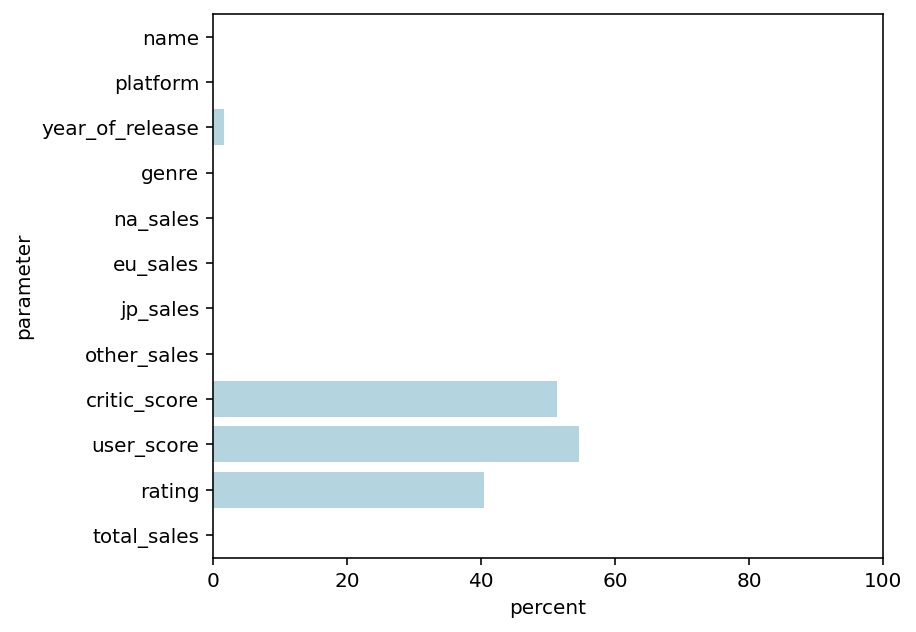

In [30]:
na_count = pd.DataFrame(data.isna().sum(axis=0)).rename(columns={0: "nans"}).reset_index()
na_count['percent'] = 100 * na_count['nans'] / data.shape[0]

fig, ax = plt.subplots(figsize=(6, 5))
sns.barplot(data=na_count, y='index', x='percent', orient='h', ax=ax, color='lightblue')
ax.set(xlim = (0, 100), ylabel="parameter");

Пропуски имеются в 4 столбцах: `critic_score`, `user_score`, `rating` и `year_of_release`.

* Год выпуска `year_of_release` похоже на случайный пропуск. Возможно год указан в названии, хотя даже если и указан, то не факт, что это будет годом релиза. Впринципе, их всего 267 штук, что состовляет всего 1.6 % от всего датасета, так что можно их и потереть и тогда сразу переведем стоблец в целочисленный формат

In [31]:
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = data["year_of_release"].astype(int)

* Три параметра с оценками `critic_score`, `user_score`. Пропусков в этих данных много, то есть возможно, какая-то ошибка при парсинге или выгрузке данных.
Не очень хочется трогать эти пропуски, так как для двух случаев их больше половины от всех значений. Получается, что если я буду заполнять их средним значением или медианой, то скорее всего испорчу общее распределение. В целом, обобщать большее от меньшего без знания какой-либо закономерности, наверное, не стоит.

Помимо этого, может я и придираюсь, но сами по себе оценки без привязки ко времени особо не дают ценности. Например, если взять человека, поигравшего в гонки, которые вышли совсем меньше года назад, и затем дать ему игру 15-ти летней давности. Вероятнее всего, оценка последней игры будет минимальной вне зависимости от геймплея. Просто потому что 15 лет для игровой индустрии - цифра огромная. Конечно, есть и исключения `Heroes of Might and Magic III`, например, но таких игр единицы и они легендарные. Поэтому я и считаю, что оценки без привязки ко времени не так ценны, как показатели продаж. Конечно, мы будем использовать доступные данные по оценкам, так как это все-таки отзывы об играх, но основной величиной я бы назвал продажи.

* `rating` заполним пропуски как `not defined` и попытаемся использовать это в дальнейшем

In [32]:
data.loc[data['rating'].isna(), 'rating'] = 'not defined'

## Исследовательский анализ данных 

### Количество игр выпущенное в разные годы

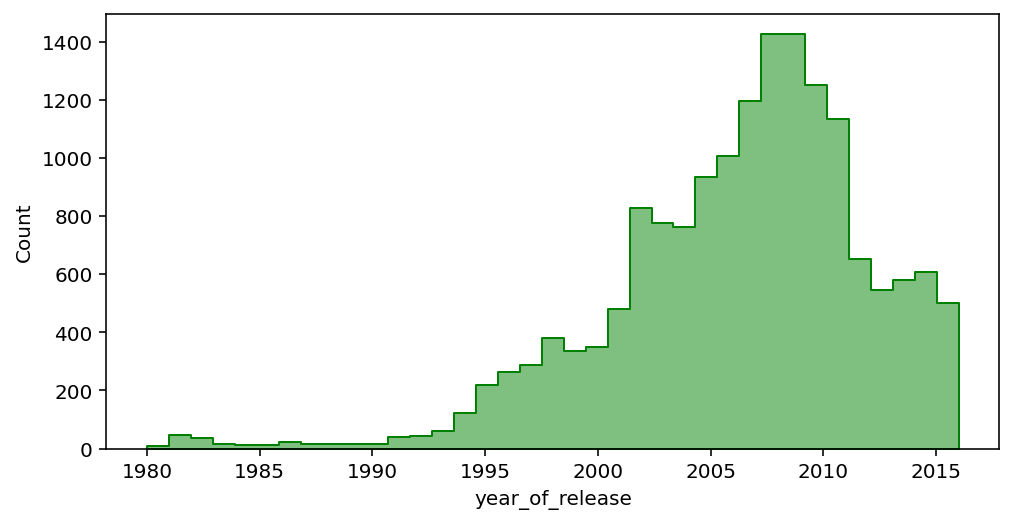

In [33]:
fig, ax = plt.subplots(figsize=(8, 4))
sns.histplot(
    ax=ax,
    data=data, 
    x='year_of_release', 
    bins=37,
    element='step',
    alpha=0.5,
    color='green'
);

In [34]:
sales_per_year_count = data.pivot_table(
    index='year_of_release',
    values='total_sales', 
    aggfunc='count'
)
sales_per_year_count.tail(10)

,total_sales
year_of_release,
2007,1197
2008,1425
2009,1425
2010,1251
2011,1134
2012,652
2013,544
2014,581
2015,606


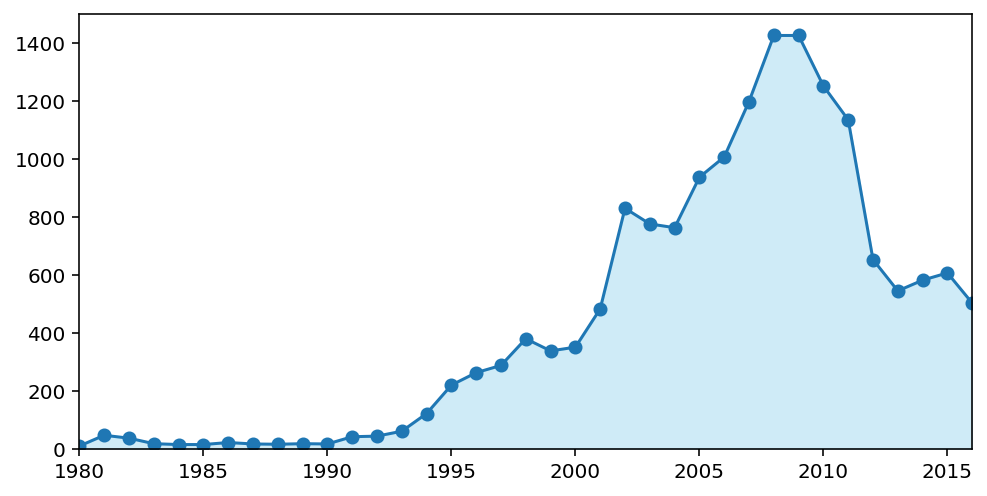

In [35]:
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(sales_per_year_count.index, sales_per_year_count['total_sales'], '-o')
ax.fill_between(sales_per_year_count.index, sales_per_year_count['total_sales'],
    alpha=0.4,
    color='skyblue'
)
ax.set_xlim(1980, 2016)
ax.set_ylim(0, 1500);

Опираясь на этот [источник](https://ru.wikipedia.org/wiki/%D0%A1%D0%BF%D0%B8%D1%81%D0%BE%D0%BA_%D0%B8%D0%B3%D1%80%D0%BE%D0%B2%D1%8B%D1%85_%D0%BA%D0%BE%D0%BD%D1%81%D0%BE%D0%BB%D0%B5%D0%B9), можно объяснить всплески около 2002, 2007-2009 годов тем, что выходили новые игровые приставки топовых фирм (`play station` - `sony`, `xbox` - `microsoft`, `wii` - `Nintendo`). В 2000-2001 это приставки шестого поколения, в 2005-2007 седьмого. Плюс год-два уходил на адаптацию или разработку игр на новые платформы, поэтому пик продаж отстает от даты выхода приставок. 

Спад после 2010 года можно попробовать связать с появлением конкурента. У меня на ум приходят только смартфоны. В 2008 году начал выходить новый iphone 3, вроде бы, и видимо часть людей стала уходить в мобильную разработку.

Также совсем ничего не происходило вплоть до 1993 года, поэтому уберем все вплоть до этого момента

In [37]:
data = data.query('year_of_release > 1993')

### Распределение продаж по платформам

In [38]:
platfrom_sales_per_year = data.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum', 
    fill_value=0
)

Будем рассматривать только платформы, которые за рассматриваемый нами период смогли продать более 100 млн копий игр

In [39]:
platform_till_2016 = platfrom_sales_per_year.columns[platfrom_sales_per_year.loc[2016] > 0]

In [40]:
subset = platfrom_sales_per_year.loc[2006:, platform_till_2016]\
    .sum(axis=0)\
    .sort_values(ascending=False)[:10]
subset

platform
x360    952.99
ps3     931.33
wii     890.52
ps4     314.14
3ds     257.81
pc      163.29
xone    159.32
wiiu     82.19
psv      53.81
dtype: float64

In [41]:
best_sellers_names = subset.index

In [42]:
best_sellers_data = data.query("platform in @best_sellers_names")

In [43]:
best_sellers_group = best_sellers_data.groupby(by=['year_of_release', 'platform']).agg(
    sales=('total_sales', 'sum'),
).reset_index()

Для графика перепишу имена платформ в таком порядке

In [44]:
best_sellers_names = [ 'wii', 'pc', 'x360', 'ps3', 'psv', '3ds', 'wiiu', 'ps4', 'xone']

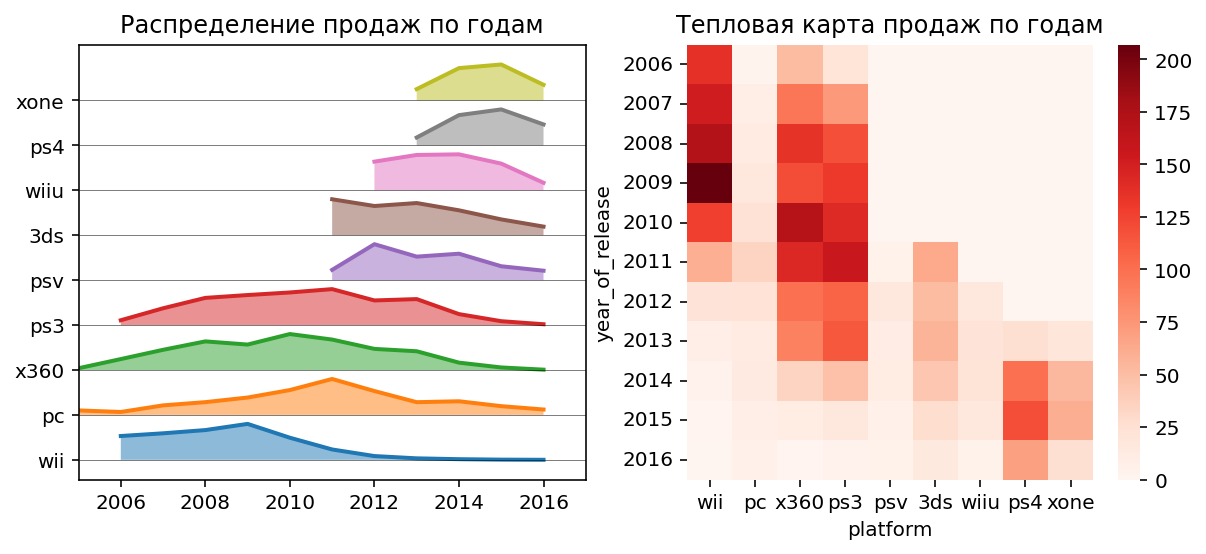

In [45]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
for i, name in enumerate(best_sellers_names):
    x = best_sellers_group.loc[best_sellers_group['platform'] == name, 'year_of_release']
    y = best_sellers_group.loc[best_sellers_group['platform'] == name, 'sales']
    
    ax[0].fill_between(x, 1.25*i, 1.25*i + y/y.max(), alpha=0.5)
    ax[0].plot(x, 1.25*i + y/y.max(), lw=2)
    ax[0].hlines(1.25*i, 2005, 2017, lw=0.25, color='k')
ax[0].set_xlim(2005, 2017)
ax[0].set_title("Распределение продаж по годам")
ax[0].set_yticks(1.25 * np.arange(len(best_sellers_names)))
ax[0].set_yticklabels(best_sellers_names)


sns.heatmap(platfrom_sales_per_year.loc[2006:, best_sellers_names], cmap=plt.cm.Reds, ax=ax[1])
ax[1].set_title('Тепловая карта продаж по годам');

По нормированному графику распределения продаж  для каждой платформы по годам можно визуально оценить актуальность платформы в настоящее время и приблизительное время жизни каждой из них. Так мы можем сказать, что среднее время жизни составляет около $\color{blue}{6-7 лет}$, затем выходит уже либо новая версия платформы, либо платформы устаревают и для них уже не делают игры. Также можно сказать, что на данный момент стоит опираться в большей степени на такие платформы как `xone`, `ps4`, `3ds`, `pc`. При этом как-то не верится в то, что у `ps4` стали падать продажи, так как платформа живет только четвертый год, а ее предшественники были долгожителями. Соответственно, 2016 год - странный)

По тепловой карте можно добавить, что одними из самых успешных платформ за все $\color{blue}{рассматриваемое}$ время были `ps3`, `wii` и `x360`. Но плохо видно выживаемость `pc`.


### Анализ актуальных платформ

Опираясь на предыдущие результаты оставим для дальнейшего анализа данные за 3 года, то есть с 2012-2015 включительно. По условию мы находимся в декабре 2016 года, и данные по этому году должны быть почти полные, но из данных так не кажется.

In [46]:
relevant_data = data.query("2012 <= year_of_release < 2016")

In [47]:
relevant_platfrom_sales_per_year = relevant_data.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum', 
    fill_value=0
)

In [48]:
relevant_platfrom_sales_per_year

platform,3ds,ds,pc,ps3,ps4,psp,psv,wii,wiiu,x360,xone
year_of_release,,,,,,,,,,,
2012,51.36,11.01,23.22,107.35,0.00,7.69,16.19,21.71,17.56,99.74,0.00
2013,56.57,1.54,12.38,113.25,25.99,3.14,10.59,8.59,21.65,88.58,18.96
2014,43.76,0.00,13.28,47.76,100.00,0.24,11.90,3.75,22.03,34.74,54.07
2015,27.78,0.00,8.52,16.82,118.90,0.12,6.25,1.14,16.35,11.96,60.14


Отобрались все платформы за период с 2012 по 2015 годы. Сюда попали как молодые платформы: `ps4`, `xone`, так и уже увядающие: `psv`, `wii`, `ps3`, `x360`, ну и вечный `pc`.

Сразу уберем совсем старенькие платформы, чтобы на них не отвлекаться

In [49]:
stay = ['wii', 'pc', 'x360', 'ps3', '3ds', 'wiiu', 'ps4', 'xone']
relevant_data = relevant_data.query("platform in @stay")

Перестроим табличку

In [50]:
relevant_platfrom_sales_per_year = relevant_data.pivot_table(
    index='year_of_release',
    columns='platform',
    values='total_sales',
    aggfunc='sum', 
    fill_value=0
)

Посмотрим лидеров по общим продажам за выделенный период

In [51]:
relevant_platfrom_sales_per_year.sum(axis=0).sort_values(ascending=False)

platform
ps3     285.18
ps4     244.89
x360    235.02
3ds     179.47
xone    133.17
wiiu     77.59
pc       57.40
wii      35.19
dtype: float64

В топ-3 две платформы старого поколения `ps3` и `x360`, а также относительно свежая `ps4`.

In [52]:
for_plot = relevant_data.pivot_table(
    index=('year_of_release', 'platform'),
    values='total_sales',
    aggfunc='sum', 
    fill_value=0
).reset_index()

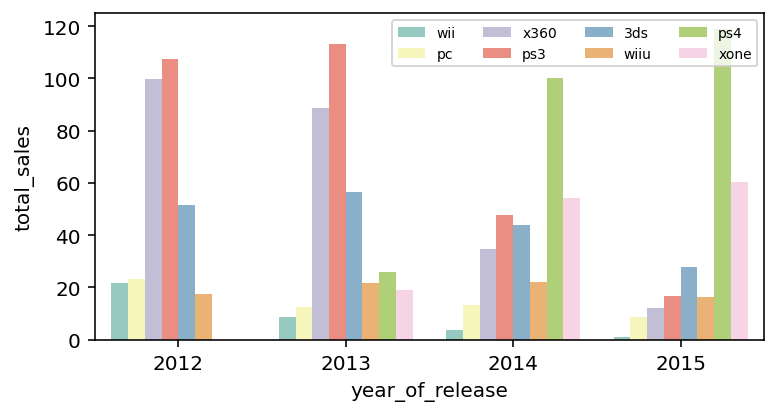

In [53]:
fig, ax = plt.subplots(figsize=(6, 3))
sns.barplot(
    data=for_plot, 
    x='year_of_release', 
    y='total_sales',
    hue='platform', 
    hue_order=stay,
    ci=None,
    palette="Set3",
    ax=ax
)
ax.legend(fontsize='x-small', ncol=len(for_plot['platform'].unique())//2);

    
Мы можем утверждать, что на данный момент лидируют по продажам две платформы одного производителя `sony`: `ps3` и `ps4`. Продажи первой падают, так как уже несколько лет как выпущена ее современная версия: `ps4`, которая прибавляет в продажах. Также отметим и рост продаж приставки `xone`, которая пришла на смену довольно популярной `x360` компании `microsoft`. Причем стоит отметить, что эти компании выпустили новые версии своих платформ спустя год-два после начала падения продаж для более старых версий. 

Также из современных платформ нужно сказать о `3ds` и `wiiu` они также как и `ps4`, `xone` вышли в начале падения `ps3` и `x360` и даже поначалу имели больший успех, нежели `ps4`, `xone`. Возможно из-за более доступной цены, но сейчас продажи `3ds` падают на фоне `ps4` и `xone`, а `wiiu` выходят на плато. В первом случае идет уже 6-ой год релиза платформы и падение ожидаемо, а для `wiiu` идет только пятый год и я ожидаю снижения в последующих годах. Однако для `wiiu` настораживает, что вырисовывается именно плато, то есть возможно есть какой-то фан-клуб этого производителя.

Итак, из потенциально прибыльных платформ я бы выбрал `ps4`, `xone`, но и не стал бы сбрасывать со счетов `wiiu` и `pc`. Про `wiiu` я уже говорил, что есть ощущение о наличии фан-клуба этой фирмы. А `pc` вечный) Эта категория не будет давать бешеных доходов, но будет давать его стабильно, так как распространенность `pc` намного больше.
</div>

### Box-plot
Построим еще и графики box-plot для наших топ-4 платформ и текущих лидеров продаж

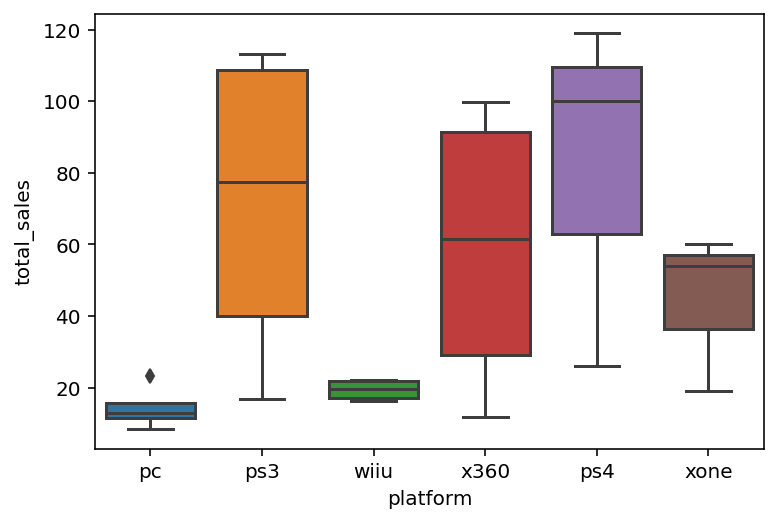

In [54]:
sns.boxplot(
    data=for_plot.query("platform in ('pc', 'wiiu', 'ps4', 'xone', 'ps3', 'x360')"),
    y='total_sales',
    x='platform',
);

Получается медианному числу продаж новый `ps4` в рассматриваемом промежутке времени даже обходит `x360`. В целом перспективными я бы назвал только две платформы `ps4`, `xone`. Так как они продолжителя лидерующих платформ и по времени жизни еще не подошли к своему пику. `wiiu` и `pc` хоть и импонируют мне, но называть их перспективными , не совсем верно. Хотя, можно, `pc` тоже оставить из-за его устойчивости на рынке, то есть это платформы, которые дадут прибыль, но даже пик их продаж меньше нижнего порога `ps4`.

### Влияние отзывой пользователей и критиков
Вначале я довольно скептически отнесся к оценкам пользователей и критиков. Давайте теперь посмотрим существует ли ними какая-нибудь связь на самом деле, например, для `ps4`.

In [55]:
scores_ps4 = relevant_data.query("platform == 'ps4'")\
    .sort_values(by='year_of_release')\
    .reset_index(drop=True)

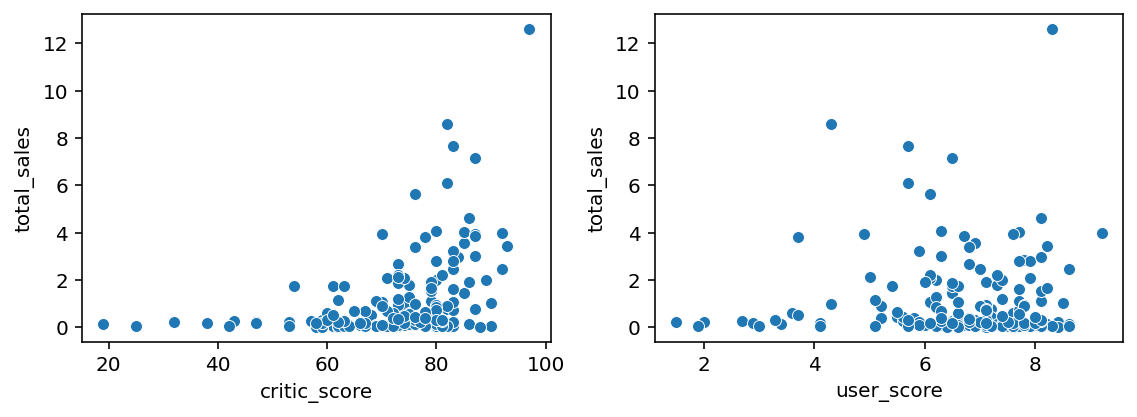

In [56]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
sns.scatterplot(
    ax=ax[0],
    x='critic_score', 
    y='total_sales', 
    data=scores_ps4
)

sns.scatterplot(
    ax=ax[1],
    x='user_score', 
    y='total_sales', 
    data=scores_ps4
);

Непохоже на выраженную зависимость между отзывами и продажами, чтобы убедиться наверняка посчитаем корреляции между ними

In [57]:
scores_ps4[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.431848,0.024231
critic_score,0.431848,1.000000,0.612451
user_score,0.024231,0.612451,1.000000


Получается, что я был не совсем прав. Корреляция между отзывами критиков и продажами существует, а вот оценки пользователей совсем не влияют на показатель продаж.

#### Сравнение с другой платформой
Проведем такой же анализ только с для других платформ

In [58]:
scores_other = relevant_data.query("platform in ('ps3', 'x360', 'xone')")\
    .sort_values(by='year_of_release')\
    .reset_index(drop=True)

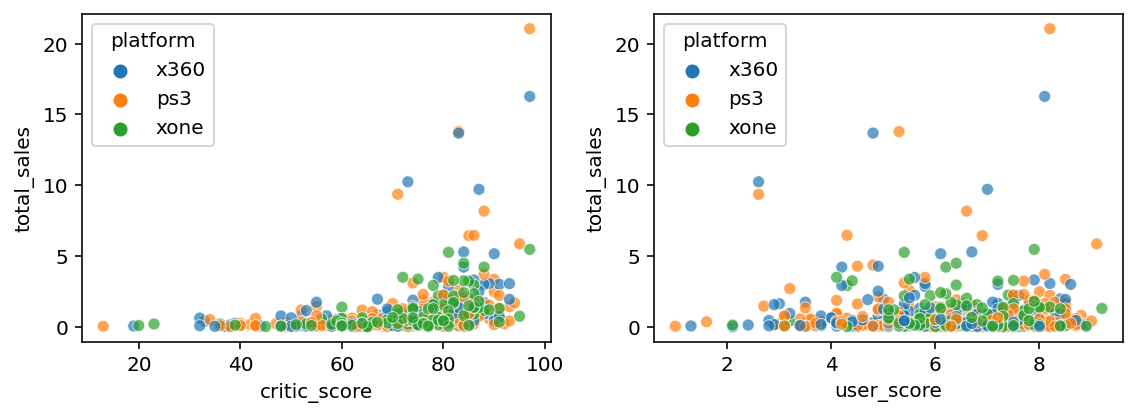

In [59]:
fig, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)
sns.scatterplot(
    ax=ax[0],
    x='critic_score', 
    y='total_sales', 
    hue='platform',
    data=scores_other,
    alpha=0.7
)

sns.scatterplot(
    ax=ax[1],
    x='user_score', 
    y='total_sales', 
    hue='platform',
    data=scores_other,
    alpha=0.7
);

In [60]:
scores_other[['total_sales', 'critic_score', 'user_score']].corr()

,total_sales,critic_score,user_score
total_sales,1.000000,0.353324,-0.019839
critic_score,0.353324,1.000000,0.535899
user_score,-0.019839,0.535899,1.000000


Результаты примерно такие же. Коэффиценты изменились, но незначительно

### Распределение игр по жанрам

In [61]:
stat_per_genre = relevant_data.pivot_table(
    index='genre',
    values='total_sales',
    aggfunc='sum'
).reset_index()\
 .sort_values(by='total_sales', ascending=False)

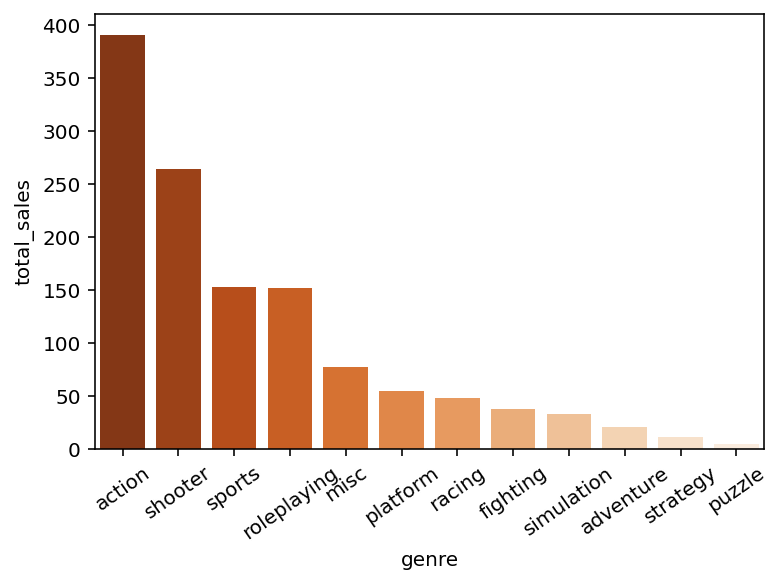

In [62]:
fig, ax = plt.subplots()
sns.barplot(
    ax=ax, 
    data=stat_per_genre, 
    x='genre', 
    y='total_sales', 
    palette='Oranges_r'
)
ax.set_xticklabels(stat_per_genre['genre'], rotation=35);

Итак, в топ-5 жанров по продажам вошли:
1. Action 
2. Shooter
3. Sports
4. Roleplaying
5. [Misc или Miscellaneous](https://kritikanstvo.ru/top/games/best/alltime/genres/62/) (вообще я думал, это action жанр ¯\\_(ツ)_/¯)

PS: за стратегии обидно

Еще можно посмотреть по медианам. Так мы избежим выбросов и будем ориентироваться на жанры, где игры в большинстве приносят больше прибыли

In [63]:
stat_per_genre = relevant_data.pivot_table(
    index='genre',
    values='total_sales',
    aggfunc='median'
).reset_index()\
 .sort_values(by='total_sales', ascending=False)

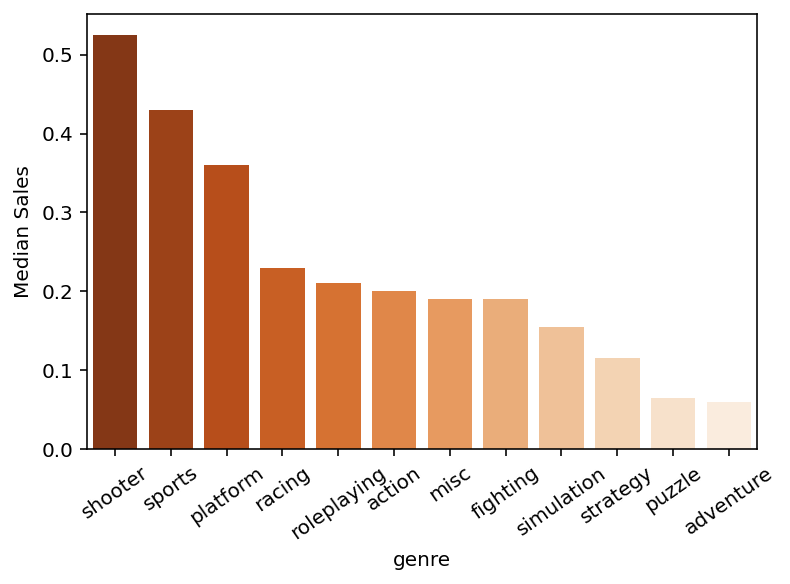

In [64]:
fig, ax = plt.subplots()
sns.barplot(
    ax=ax, 
    data=stat_per_genre, 
    x='genre', 
    y='total_sales', 
    palette='Oranges_r'
)
ax.set_ylabel("Median Sales")
ax.set_xticklabels(stat_per_genre['genre'], rotation=35);

Медиана дала совсем другое представление о популярности жанров. `action` откатился аж на шестую позицию. Получается, что просто очень много игр выпускается в этом жанре, но их эффективность не самая лучшая (то есть выстреливают единицы). А вот Shooter, Sports и Roleplaying получается держат марку
    
Сделаем топ по медианным значениям продаж:
1. Shooter
2. Sports
3. Platform
4. Racing
5. Roleplaying


### Портреты пользователей в регионах

#### Самые популярные платформы в регионах

In [65]:
region_sales = relevant_data.pivot_table(
    index='platform', 
    values=["eu_sales", "jp_sales", "na_sales", "other_sales"],
    aggfunc='sum'
)

In [66]:
region_sales_percent = region_sales.apply(lambda x: 100*x/x.sum(), axis=0)

In [67]:
def make_pies(i):
    top = np.argsort(region_sales_percent.iloc[:, i].values)[::-1]
    top_5 = top[:5]
    other = top[5:]
    values = list(region_sales_percent.iloc[top_5, i])
    values.append(region_sales_percent.iloc[other, i].sum())
    labels = list(region_sales_percent.index[top_5]) 
    labels.append('others')
    return values, labels, np.array(colors)[np.arange(9)[top[:6]]]

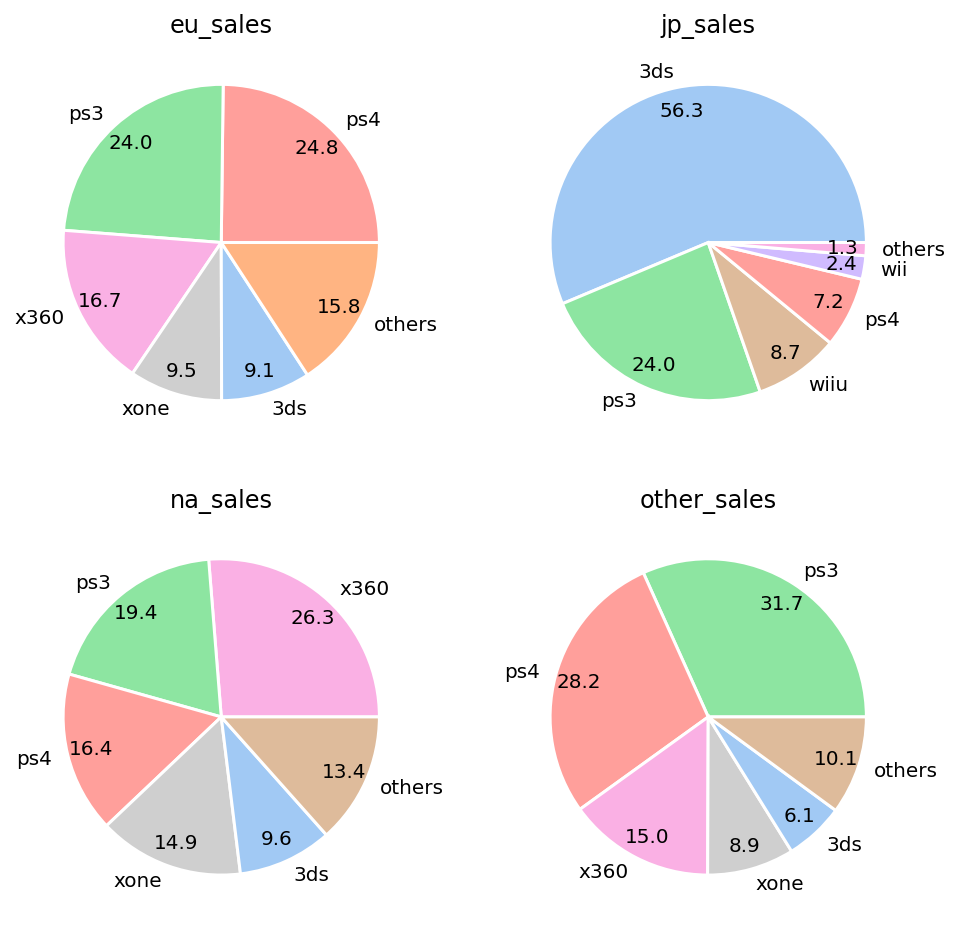

In [68]:
colors = sns.color_palette('pastel')[0:9]
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, axis in enumerate(ax.flatten()):
    
    vals, labs, color = make_pies(i)
    axis.pie(vals, 
        autopct='%.1f',
        pctdistance=0.85,
        labels=labs,
        wedgeprops={'linewidth': 1.5, 'edgecolor': 'white'},
        colors=color
    )
    axis.set_title(region_sales_percent.columns[i])

Здесь мы видим, что `eu_sales` и `other_sales` по долям ведут себя примерно одинаково. У них совпадает топ-5 платформ. В приоритете находятся `ps3`, `x360` и `ps4`, но доля `ps3` пользователей у `other_sales` повыше **32%** против **24%** у `eu_sales`. Несколько иное поведение наблюдается в Северной Америке. Лидирует `x360` на него приходится **26%**. Далее идут **`ps3`, `ps4` и `xone` с показателями в 19%, 16% и 15% соответственно**. В `jp_sales` кардинально другая ситуация. Лидирует `3ds` с показателем в **56%**, второе место `ps3` - 24% и третье место **`wii` - 9%**. Получается японские геймеры абсолютно равнодушны к американской консоли. Что самое забавно по абсолютно не игровой [причине](https://www.japan-zone.com/features/103_why_xbox_failed_in_japan.shtml). Согласно источнику `xbox` не покупается в японцами из-за того, что первоначально занимал много место в квартире. А так как у японцев квартиры небольшие, то его и не берут. Затем в Японии был взят курс на поддержку отвечественного производителя `sony`... gg 


#### Самые популярные жанры в регионах

In [69]:
region_genre = relevant_data.pivot_table(
    index='genre', 
    values=["eu_sales", "jp_sales", "na_sales", "other_sales"],
    aggfunc='median'
)

In [70]:
region_genre_percent = region_genre.apply(lambda x: 100*x/x.sum(), axis=0)
region_genre_percent

,eu_sales,jp_sales,na_sales,other_sales
genre,,,,
action,6.329114,0.000000,7.777778,4.651163
adventure,2.531646,0.000000,0.000000,0.000000
fighting,3.797468,35.294118,6.666667,9.302326
misc,5.063291,0.000000,8.888889,4.651163
platform,15.189873,0.000000,18.333333,16.279070
puzzle,0.000000,5.882353,0.000000,0.000000
racing,16.455696,0.000000,7.222222,9.302326
roleplaying,3.797468,58.823529,6.111111,4.651163
shooter,26.582278,0.000000,24.444444,27.906977


In [71]:
def make_pies(i):
    n = 5 # top_5
    top = np.argsort(region_genre_percent.iloc[:, i].values)[::-1]
    if i == 1: #ja_sales
        n = 3
    top_5 = top[:n]
    other = top[n:]
    
    values = list(region_genre_percent.iloc[top_5, i])
    values.append(region_genre_percent.iloc[other, i].sum())
    labels = list(region_genre_percent.index[top_5]) 
    labels.append('others')
    return values, labels, np.array(colors)[np.arange(region_genre_percent.shape[0])[top[:n+1]]]

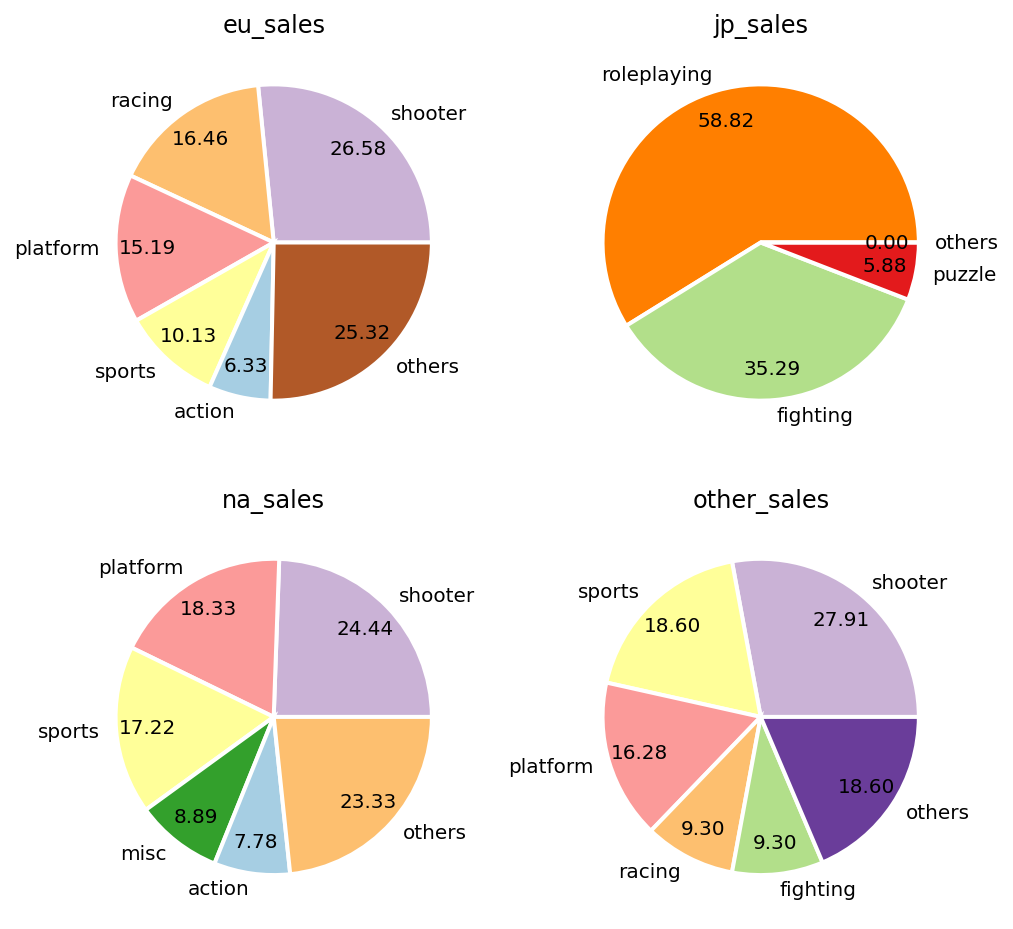

In [72]:
colors = sns.color_palette('Paired')
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, axis in enumerate(ax.flatten()):
    
    vals, labs, color = make_pies(i)
    axis.pie(vals, 
        autopct='%.2f',
        pctdistance=0.8,
        labels=labs,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
        colors=color
    )
    axis.set_title(region_genre_percent.columns[i])

  
При разбиении по жанрам можно сказать, что `eu_sales`, `na_sales` и `other_sales` имеют схожие предпочтения. Так в этих регионах лидируют игры жанра `shooter` и составляют приблизительно 24-28%. Топ-3 в Америке и остальном мире замыкают `platform` и `sports` с показателями в 16-18 и 17-19 процентов соответственно. В европе же на втором месте идет жанр `racing`, а третьем `platfrom`.
Начиная с 4 и 5 позиций уже вылезают отклонения из общих тенденций. В `na_sales` отдают предпочтения `misc` и `action`, в `eu_sales`: `sports` и `action`. А в `other_sales` это `racing` и `fighting`. 

Касательно `ja_sales`, то здесь жанры распределились следующим образом: `roleplaying` - 58%, `fighting` - 35% и `misc` - 6%


#### Самые популярные рейтинги в регионах

In [73]:
region_esrb = relevant_data.pivot_table(
    index='rating', 
    values=["eu_sales", "jp_sales", "na_sales", "other_sales"],
    aggfunc='sum'
)

In [74]:
region_esrb_percent = region_esrb.apply(lambda x: 100*x/x.sum(), axis=0)
region_esrb_percent

,eu_sales,jp_sales,na_sales,other_sales
rating,,,,
E,21.725515,18.637006,19.551735,19.985202
E10+,11.157756,5.324859,13.266980,10.640030
M,39.675048,12.768362,40.000754,42.056974
T,9.410457,12.860169,10.279176,10.136885
not defined,18.031224,50.409605,16.901355,17.180910


In [75]:
def make_pies(i):
    top = np.argsort(region_esrb_percent.iloc[:, i].values)[::-1]
    values = list(region_esrb_percent.iloc[top, i])
    labels = list(region_esrb_percent.index[top]) 
    return values, labels, np.array(colors)[np.arange(region_esrb_percent.shape[0])[top]]

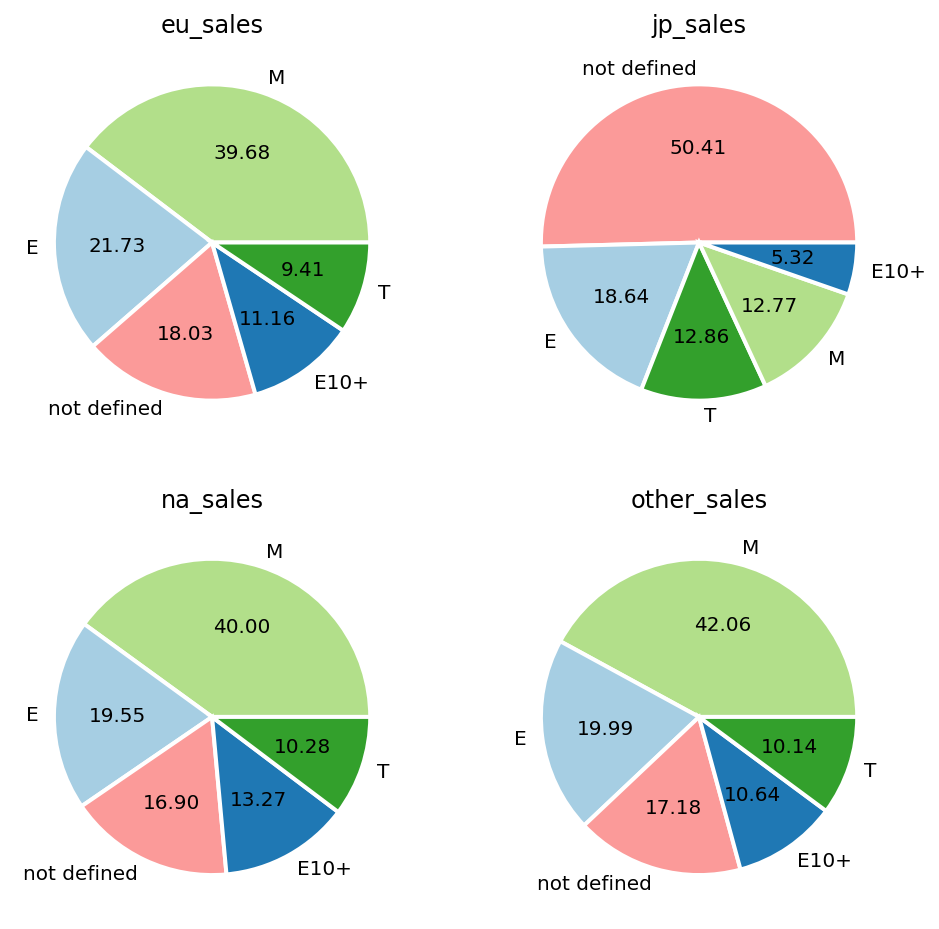

In [76]:
colors = sns.color_palette('Paired')
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i, axis in enumerate(ax.flatten()):
    
    vals, labs, color = make_pies(i)
    axis.pie(vals, 
        autopct='%.2f',
        labels=labs,
        wedgeprops={'linewidth': 2, 'edgecolor': 'white'},
        colors=color
    )
    axis.set_title(region_esrb_percent.columns[i])

В целом везде мажорируют одинаковые категории: M, E им соответствуют расшифровки: >17 лет, для всех.
В Америке, Европе и остальной мире примерно 17% от выручке относится и играм, для которых еще не определен возрастной диапазон. В Японии доля выручки от неопределенной категории превышает 50%.

Соответсвенно для Америки, Европы и остальной мира можно делать акцент на производство игр в категориях M и E. То есть в Америке, Европе и остальной мире - играют в основном взрослые. Для Японии я считаю не корректным выделение определенных катерогий, кроме E.

Вообще сильные отклонение в показателях у Японии, как мне кажется, получается из-за сильных отличий в наших культурных обычиях. 


## Проверка Гипотез

### Случай 1
$H_0$ : Средние пользовательские рейтинги платформ `xone` и `pc` одинаковые

Соответственно, обратное утверждение это альтернативная гипотеза

$H_1$: Средние пользовательские рейтинги платформ `xone` и `pc` разные

Проверяем равенство средних значений двух независимых выборок. Для проверки применим критерий t-Стьюдента

In [77]:
xone = relevant_data.query('(platform == "xone") & (user_score >= 0)')['user_score']
pc = relevant_data.query('(platform == "pc") & (user_score >= 0)')['user_score']

In [78]:
alpha = 0.05
results = st.ttest_ind(xone, pc)
print(f'p-value: {results.pvalue}')
if (results.pvalue < alpha):
    print("Отклоняем нулевую гипотезу")
else:
    print("Принимаем нулевую гипотезу")

p-value: 0.9463196313131613
Принимаем нулевую гипотезу


Получается, что средние пользовательские рейтинги для  платформ `xone` и `pc` действительно одинаковые

### Случай 2
Проверяем равенство средних значений двух независимых выборок.

$H_0$ : Средние пользовательские рейтинги жанров `action` и `sports` одинаковые

$H_1$: Средние пользовательские рейтинги жанров `action` и `sports` разные

Также применим t-тест Стьюдента

In [79]:
action = relevant_data.query('(genre == "action") & (user_score >= 0)')['user_score']
sports = relevant_data.query('(genre == "sports") & (user_score >= 0)')['user_score']

In [80]:
alpha = 0.05
results = st.ttest_ind(action, sports)
print(f'p-value: {results.pvalue}')
if (results.pvalue < alpha):
    print("Отклоняем нулевую гипотезу")
else:
    print("Принимаем нулевую гипотезу")

p-value: 7.716086489474456e-23
Отклоняем нулевую гипотезу



## Вывод

По ходу анализа нами было устновлено:
1. Начиная с 2010 года, наблюдается спад продаж игр в совокупности по всем платформам. Вероятно, из-за появления конкурента в виде мобильных игр.
2. Среднее время жизни игровой платформы от 6 до 7 лет
3. По данным до 2016 года лидерами продаж являются `ps3`, `ps4` и `x360` как по суммарному числу выручки, так и по медианному. Однако пик популярности `ps3` и `x360` платформ уже прошел и продажи сильно упали и вложение на разработку игр под эти платформы крайне не рекомендуется
4. Наиболее перспективными для вложения являются игры, разрабатываемые под платформы `ps4` и `xone`, которые являются улучшенными версиями текущих лидеров продаж. Особо я бы рекомендовал `ps4`, так как игры на нее продаются и в Японии. Также можно рассматреть вложения и под `pc` вследствии ее живучести, но данная платформа способна давай невысокую, но стабильную прибыль
5. Пользовательские оценки никак не влияют на продажи игр
6. Оценки критиков действительно могут влиять на продажи, но слабо, то есть их можно использовать как второстепенный показатель
7. Если судить в совокупности по суммарному и медианному показателя наиболее перспективными являются жанры `shooter`, `sports`, `platform`, `fighting` и `roleplaying`. Последний является самым популярным жанром в Японии с большим отрывом.
8. Японский регион наиболее выделяется по следующим пунктам:
 1. До выхода `ps4` предпочтение отдавалось приставке `3ds`, на которую приходилось большинство продаж
 2. Не покупается `xone` и более старые виды этой приставки из-за плохого старта и внутренней политики страны
9. В остальных регионах играют в основном взрослые люди и предпочтения отдаются жанрам `shooter`, `sports` и `platform` в категориях M и E.
10. Популярность компаний, деляющих приставки:
 1. Америка: приставки от `Microsoft` - `x360`, `xone` чуть более популярны, нежели `ps3`, `ps4`. 
 2. Европа: ситуация обратная Америке
 3. Остальной мир: приставки от компании `sony` - `ps3`, `ps4` значительно предпочтительнее всех остальных
11. На данный момент средние пользовательские рейтинги на платформах `xone` и `pc` одинаковые
12. На данный момент средние пользовательские рейтинги по жанрам  `action` и `sports` отличаются

Таким образом, наиболее перспективным, мне кажется, вложение в разработку игр под платформу `ps4` компании `Sony`, особенно в жанрах `shooter`, `sports`, **`platform`** и `roleplaying`. Это связано с востребованностью игр на приставках этого производителя в предыдущие годы (`ps3`). Также время жизни платформы еще не подошло к среднему. Игры под эту приставку продаются во всех регионах мира.
</div>